## Retinal Multi Disease Classification
<img src="https://i.ibb.co/6szKmbL/Folder-Organisation.jpg" alt="data" style="width: 400px;">

<img src="https://i.ibb.co/pxFk0TG/composition.jpg" alt="data" style="width: 400px;">

**Notebook and GPU preparation with Google Colab**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
and then re-execute this cell.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Retinal_Disease/retinal_disease.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

KeyboardInterrupt: ignored

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)


**Packages and data preprocessing**

In [ ]:
#Importation of packages and datasets
import os 
from tqdm import tqdm
from glob import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf

from warnings import filterwarnings
filterwarnings('ignore')


print(os.getcwd())
path_cwd = os.getcwd()

X_train = pd.read_csv('/content/Training_Labels.csv')
X_val = pd.read_csv('/content/Validation_Labels.csv')
X_test = pd.read_csv('/content/Test_Labels.csv')

/content


In [ ]:
X_train.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.describe()
#No missing value

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.0,1920.000000,1920.000000,1920.0,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,960.500000,0.791146,0.195833,0.052083,0.165104,0.071875,0.052604,0.038021,0.096875,0.007292,0.024479,0.007812,0.019271,0.146875,0.014583,0.003125,0.008333,0.033854,0.030208,0.002604,0.008854,0.005729,0.007292,0.022396,0.016667,0.007812,0.011458,0.005729,0.003125,0.001563,0.000521,0.0,0.001042,0.001563,0.0,0.001042,0.001563,0.002083,0.002604,0.001563,0.000521,0.000521,0.000521,0.001042,0.000521,0.000521,0.000521
std,554.400577,0.406596,0.396944,0.222253,0.371371,0.258348,0.223300,0.191296,0.295865,0.085102,0.154572,0.088065,0.137511,0.354073,0.119909,0.055829,0.090930,0.180901,0.171205,0.050978,0.093703,0.075494,0.085102,0.148006,0.128052,0.088065,0.106456,0.075494,0.055829,0.039508,0.022822,0.0,0.032266,0.039508,0.0,0.032266,0.039508,0.045608,0.050978,0.039508,0.022822,0.022822,0.022822,0.032266,0.022822,0.022822,0.022822
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,480.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,960.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1440.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1920.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#reconstituion link image + drop ID feature
X_train['filename'] = X_train.apply(lambda x : "/content/Training/" +str(x['ID']) + ".png", axis=1)
X_val['filename'] = X_val.apply(lambda x : "/content/Validation/" +str(x['ID']) + ".png", axis=1)
X_test['filename'] = X_test.apply(lambda x : "/content/Test/" +str(x['ID']) + ".png", axis=1)

X_train = X_train.drop('ID', axis=1)
X_val = X_val.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

In [ ]:
print(X_train.head(1))
print(X_train.shape)
#46 class + risk evaluation (47 features)

   Disease_Risk  DR  ARMD  MH  DN  ...  BRAO  PLQ  HPED  CL                 filename
0             1   1     0   0   0  ...     0    0     0   0  /content/Training/1.png

[1 rows x 47 columns]
(1920, 47)


In [ ]:
#datasets
X_train_img = X_train['filename']
X_val_img = X_val['filename']
y_train = X_train.drop(['filename'], axis=1)
y_val = X_val.drop(['filename'], axis=1)

print('shape of X_train:', X_train_img.shape)
print('shape of Validation:', X_val_img.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_val:', y_val.shape)

shape of X_train: (1920,)
shape of Validation: (640,)
shape of y_train: (1920, 46)
shape of y_val: (640, 46)


In [ ]:
#Plot some random images
import cv2
import random
def plotImages():
    i=1
    plt.figure(figsize=(15,10))
    for r in random.sample(glob(path_cwd + '/Training/**'), 15):
      plt.subplot(3,5,i)
      img = cv2.imread(r)
      img = tf.reverse(img, axis=[-1])
      img =  tf.image.adjust_contrast(img, 1.5)
      plt.imshow(img)
      i+=1
      plt.axis('off')

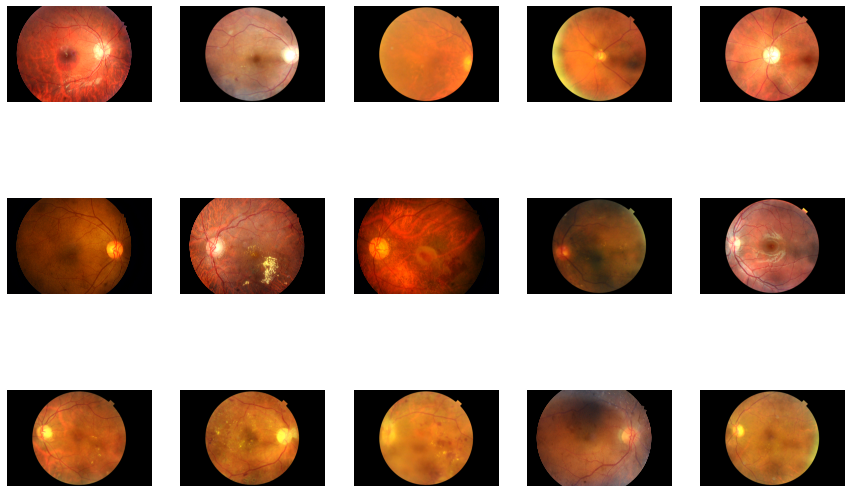

In [ ]:
plotImages() #Seems we have to convert to RGB format

## Preprocessing images

In [ ]:
IMG_SHAPE = (300, 450)
BATCH_SIZE = 64

In [ ]:
@tf.function

#Fonction pour prprocessing des images
def scale_down(img):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, (300, 450), method='nearest')
    img = (img / 255)
    
    return img

#Preprocessing du jeu d'entrainement
def preprocessing_data(img):
   
    #Lecture et décodage des images:
    img = tf.io.read_file(img)
    img = tf.io.decode_png(img, channels=3)

    #adjust contrast
    img =  tf.image.adjust_contrast(img, 1.35)

    #Resize
    img = scale_down(img)

    return img


In [ ]:
#Datasets preprocessing
AUTO = tf.data.experimental.AUTOTUNE

y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_img, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_img, y_val))

dataset_train=(dataset_train
               .shuffle(1000)
               .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(AUTO)
               )

dataset_val=(dataset_val
             .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
             .batch(BATCH_SIZE, drop_remainder=True)
             .prefetch(AUTO)
             )


print(dataset_train)
print(dataset_val)

<PrefetchDataset shapes: ((64, 300, 450, 3), (64, 46)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((64, 300, 450, 3), (64, 46)), types: (tf.float32, tf.float32)>


In [ ]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


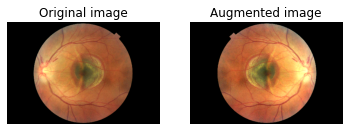

In [ ]:
image, label = next(iter(dataset_train))
image, label = image.numpy()[0], label.numpy()[0]


flipped = tf.image.flip_left_right(image)
flipped =  tf.image.adjust_contrast(flipped, 1.35)
visualize(image, flipped)

```
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator


class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=64):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch


    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(X_train_path, y_train, train_generator, batch_size=64)
#balanced_gen_val = BalancedDataGenerator(X_val, y_val, train_generator, batch_size=64)
steps_per_epoch = balanced_gen.steps_per_epoch

```



In [ ]:
#API keras preparation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Activation, MaxPool2D, Dense, Flatten, GlobalAvgPool2D
from keras import backend as K
from tensorflow.keras.applications import VGG16
vgg16 = VGG16()

#for layer in xception.layers:
#    print(layer.name, layer)

input_2 <keras.engine.input_layer.InputLayer object at 0x7f91ec3207d0>
block1_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ec320d10>
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ec7e0110>
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x7f923a1b0dd0>
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ee823fd0>
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ec340b90>
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x7f91ec7d4c90>
block3_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ec31f190>
block3_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ec33a750>
block3_conv3 <keras.layers.convolutional.Conv2D object at 0x7f91ec32c1d0>
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x7f91ec31f150>
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ec347950>
block4_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ec7ea5d0>
block4_conv3 <keras.layers.convolutional.Con

## Global architecture VGG16:
________________________________________________________________________________
<img src="https://datascientest.com/wp-content/uploads/2021/04/illu_VGG-02.png" alt="data2" align="top" style="width: 800px;">


## Classification model

In [ ]:
shape = (250, 400,3)

def Layers(inputs, trainable=False):
    global vgg16_model
    vgg16_model = VGG16(weights='imagenet',
                        include_top=False,
                        input_tensor=inputs)
    
    if trainable == True:
        for layer in vgg16_model.layers:
            layer.trainable = True
            
    else:
        vgg16_model.trainable = False
            
    return vgg16_model.output
    
        
def Build_VGG16(trainable=False):
    
    inputs = Input(shape=shape)
    vgg16 = Layers(inputs, trainable)

    conv1 = Flatten()(vgg16_model.output)
    
    dense2 = Dense(256,activation='relu')(conv1)
    dense2 = Dropout(rate=0.2)(dense2)
    
    dense3 = Dense(128,activation='relu')(dense2)
    dense3 = Dropout(rate=0.2)(dense3)
    
    model = Dense(46,activation= 'sigmoid')(dense3)
    
    return Model(inputs=inputs, outputs = model)

model = Build_VGG16()
model.summary()

input_7 <keras.engine.input_layer.InputLayer object at 0x7f91ee4b1310>
block1_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ee4b1910>
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ee4b1ad0>
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x7f91ee4c3e90>
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ee716650>
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91edcfecd0>
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x7f91ee663890>
block3_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ee65a3d0>
block3_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ee78e290>
block3_conv3 <keras.layers.convolutional.Conv2D object at 0x7f91ee6b8750>
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x7f91ee792810>
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x7f91ee792ad0>
block4_conv2 <keras.layers.convolutional.Conv2D object at 0x7f91ee770890>
block4_conv3 <keras.layers.convolutional.Con



*   use a LR function to adapt Gradient
*   Class imbalanced, we create a loss fonction to adjust weight 



In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type] 
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]


            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:
            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)

callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=2)

In [ ]:
#Re-Weighting classes binary crossentropy

def dyn_weighted_bincrossentropy(true, pred):

    # get the total number of inputs
    num_pred = K.sum(K.cast(pred < 0.5, true.dtype)) + K.sum(true)
    # get weight of values in 'pos' category
    zero_weight =  K.sum(true)/ num_pred +  K.epsilon() 
    # get weight of values in 'false' category
    one_weight = K.sum(K.cast(pred < 0.5, true.dtype)) / num_pred +  K.epsilon()
    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return K.mean(weighted_bin_crossentropy)


def weighted_bincrossentropy(true, pred, weight_zero = 0.25, weight_one = 1):

    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return K.mean(weighted_bin_crossentropy)

In [ ]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=5000, from_logits=True, name='pr_metric') # The higher the threshold value, the more accurate it is calculated.
roc_metric = AUC(curve='ROC', num_thresholds=5000, from_logits=True, name='roc_metric') 


In [ ]:
model.compile(loss=dyn_weighted_bincrossentropy,
              optimizer =tf.keras.optimizers.Adam(),
              metrics= [roc_metric, pr_metric])

#weighted_binary_crossentropy

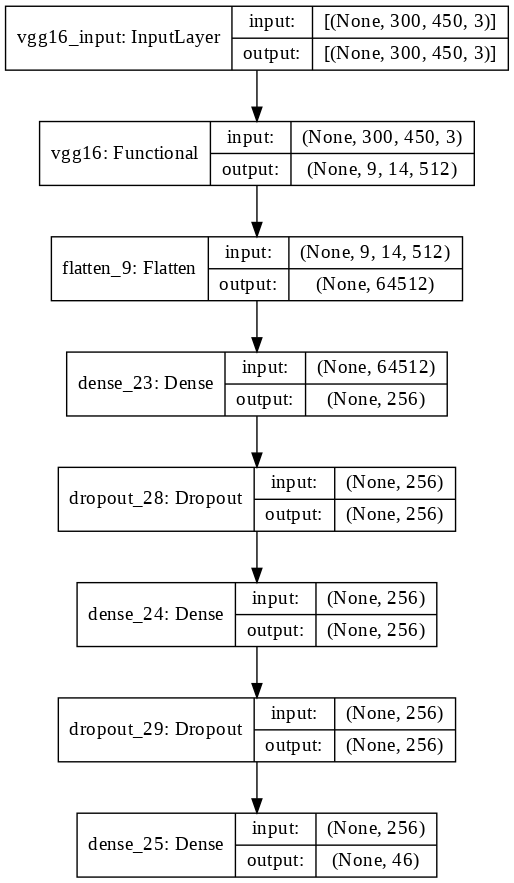

In [ ]:
tf.keras.utils.plot_model(model, 'retinal_output_model.png', show_shapes=True, dpi=100)

In [ ]:
history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    epochs=15, 
                    verbose=1, 
                   callbacks=callback_lr)

Epoch 1/15
Setting learning rate to 0.001
30/30 [==============================] - 221s 7s/step - loss: 0.0602 - roc_metric: 0.8261 - pr_metric: 0.2243 - val_loss: 0.0311 - val_roc_metric: 0.9180 - val_pr_metric: 0.6046
Epoch 2/15
Setting learning rate to 0.001
30/30 [==============================] - 219s 7s/step - loss: 0.0318 - roc_metric: 0.9097 - pr_metric: 0.5054 - val_loss: 0.0299 - val_roc_metric: 0.9263 - val_pr_metric: 0.5973
Epoch 3/15
Setting learning rate to 0.001
30/30 [==============================] - 218s 7s/step - loss: 0.0301 - roc_metric: 0.9192 - pr_metric: 0.5310 - val_loss: 0.0278 - val_roc_metric: 0.9295 - val_pr_metric: 0.5669
Epoch 4/15
Learning rate: 0.001
 7/30 [======>.......................] - ETA: 1:23 - loss: 0.0334 - roc_metric: 0.9164 - pr_metric: 0.5531

In [ ]:
from keras.models import model_from_json

model_archtecture = model.to_json()

with open('retinal_model.json', 'w') as json_file:
    json_file.write(model_archtecture)

model.save('./retinal_model')
model.save_weights('./retinal_model.h5')

INFO:tensorflow:Assets written to: ./retinal_model/assets


In [ ]:
 !zip -r /content/retinal_model.zip /content/retinal_model

  adding: content/retinal_model/ (stored 0%)
  adding: content/retinal_model/saved_model.pb (deflated 90%)
  adding: content/retinal_model/assets/ (stored 0%)
  adding: content/retinal_model/keras_metadata.pb (deflated 95%)
  adding: content/retinal_model/variables/ (stored 0%)
  adding: content/retinal_model/variables/variables.index (deflated 69%)
  adding: content/retinal_model/variables/variables.data-00000-of-00001 (deflated 35%)


## Predictions and ROC/PR curves on X_test

In [ ]:
#preparation and preprocesing
X_test_path = X_test['filename']
y_test = X_test.drop(['filename'], axis=1)
y_test = np.array(y_test).astype('float32')

print('shape of X_test:', X_test_img.shape)
print('shape of y_test:', y_test.shape)

X_test_img  = []
for filepath in tqdm(X_test_path):

  #Read and decode
  img = tf.io.read_file(filepath)
  img = tf.io.decode_png(img, channels=3)

  #adjust contrast
  img =  tf.image.adjust_contrast(img, 1.5)

  #Resize
  img = scale_down(img)
  X_test_img.append([img])


shape of X_test: (10, 1424, 2144, 3)
shape of y_test: (640, 46)


100%|██████████| 10/10 [00:00<00:00, 17.32it/s]


In [ ]:
#transform to array numpy
X_test_img = np.array(X_test_img)
X_test_img = X_test_img[:,0,:,:]
X_test_img.shape

(10, 1424, 2144, 3)

In [ ]:
y_pred = model.predict(X_test_img)

In [ ]:
from sklearn.metrics import roc_auc_score

auc_scores = []
for i in range(46):
  try:
    auc = roc_auc_score(y_test[:,i], y_pred[:,i])
    auc_scores.append(auc)
  except:
    pass


def Average(lst):
    return sum(lst) / len(lst)
  
avg_auc = Average(auc_scores)
  
# Printing average of the list
print("Average auc score available classes =", round(avg_auc, 2),'%')

Average auc score available classes = 0.78 %
